In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
import sys
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
import statistics as stats
from uncertainties import ufloat
import math

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'z':z}
df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

df = df.query('z > 0.2 & z <=0.3')

In [7]:
def low_met_agn(df): 
    x_values = df.x.values
    y_values = df.y.values.tolist()
    
    z_1 = df['z'].values
    ha_1 = df['ha'].values
    ha_err_1 = df['ha_err'].values
    hb_1 = df['hb'].values
    hb_err_1 = df['hb_err'].values
    o3_1 = df['o3'].values
    o3_err_1 = df['o3_err'].values
    n2_1 = df['n2'].values
    n2_err_1 = df['n2_err'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    
    df = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df.append('agn')
        elif x > 0.0:
            df.append('agn')
        else: 
            df.append('starform')
            
    return df, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1

In [8]:
df['x'] = np.log10(df['n2']/df['ha'])
df['y'] = np.log10(df['o3']/df['hb'])

df1 = low_met_agn(df)

In [9]:
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z']

In [10]:
dfagn = df1[df1.Type != 'starform']
dfsf = df1[df1.Type != 'agn']
dflowmetagn = df1[df1.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [11]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

4054
8651
6


In [12]:
dfsf = dfsf.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dfagn = dfagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dflowmetagn = dflowmetagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])

In [13]:
d_MPC = cosmo.luminosity_distance(dflowmetagn['z'])
dflowmetagn['d (MPC)'] = d_MPC

In [14]:
d_MPC = cosmo.luminosity_distance(dfsf['z'])
dfsf['d (MPC)'] = d_MPC

In [15]:
d_MPC = cosmo.luminosity_distance(dfagn['z'])
dfagn['d (MPC)'] = d_MPC

In [16]:
dflowmetagn['d (cm)'] = dflowmetagn['d (MPC)']*3.08567758128E+24
dfsf['d (cm)'] = dfsf['d (MPC)']*3.08567758128E+24
dfagn['d (cm)'] = dfagn['d (MPC)']*3.08567758128E+24

In [17]:
def lumin(oxy3, d_cm):
    L = (oxy3)*(4)*(np.pi)*(d_cm**2)
    return L

In [18]:
dflowmetagn['luminosity_non_bolo'] = lumin(dflowmetagn['o3'], dflowmetagn['d (cm)'])
dfsf['luminosity_non_bolo'] = lumin(dfsf['o3'], dfsf['d (cm)'])
dfagn['luminosity_non_bolo'] = lumin(dfagn['o3'], dfagn['d (cm)'])

In [19]:
dflowmetagn['luminosity_non_bolo'] = dflowmetagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfsf['luminosity_non_bolo'] = dfsf.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfagn['luminosity_non_bolo'] = dfagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

In [20]:
def bolo_lumin(L_o3):
    L_iso_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    #L_iso = np.log10(L_iso_exp)
    return L_iso_exp

In [21]:
bolo_non_log_lowmetagn = bolo_lumin(dflowmetagn['luminosity_non_bolo'])
dflowmetagn['log(bolo_lumin)'] = bolo_non_log_lowmetagn
bolo_lumin_lowmetagn = np.log10(bolo_non_log_lowmetagn)
dflowmetagn['Bolo_Lumin'] = bolo_lumin_lowmetagn

dflowmetagn['log(o3_lumin)'] = np.log10(dflowmetagn['luminosity_non_bolo'])
dflowmetagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
247,lowmetagn,31.4272,1.38418,0.265746,1350.96,4.16864e+27,6.862846e+57,54.672764,1.737771,57.836504
7537,lowmetagn,1532.35,14.4031,0.270525,1378.77,4.25444e+27,3.485396e+59,55.630883,1.745316,59.542252
8108,lowmetagn,34.9887,1.16172,0.225231,1119.79,3.45531e+27,5.249428e+57,54.607387,1.737251,57.720112
8765,lowmetagn,35.7911,1.08019,0.256781,1299.11,4.00862e+27,7.227282e+57,54.685386,1.737871,57.858975
12111,lowmetagn,33.0877,1.22081,0.272641,1391.11,4.29253e+27,7.661295e+57,54.699613,1.737984,57.884302
12700,lowmetagn,53.5768,1.4328,0.283669,1455.81,4.49215e+27,1.358615e+58,54.839360,1.739092,58.133096


In [22]:
bolo_non_log_sf = bolo_lumin(dfsf['luminosity_non_bolo'])
dfsf['log(bolo_lumin)'] = bolo_non_log_sf
bolo_lumin_sf = np.log10(bolo_non_log_sf)
dfsf['Bolo_Lumin'] = bolo_lumin_sf

dfsf['log(o3_lumin)'] = np.log10(dfsf['luminosity_non_bolo'])
dfsf

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
0,starform,9.45858,1.20216,0.228498,1138.13,3.51189e+27,1.465948e+57,54.296209,1.734770,57.166119
1,starform,30.2653,1.00338,0.286323,1471.46,4.54046e+27,7.840716e+57,54.705260,1.738029,57.894356
2,starform,15.7498,1.25893,0.202274,992.508,3.06256e+27,1.856321e+57,54.353802,1.735230,57.268653
3,starform,16.1489,1.35837,0.228571,1138.54,3.51316e+27,2.504666e+57,54.426878,1.735813,57.398750
4,starform,17.7415,1.1231,0.202244,992.345,3.06206e+27,2.090388e+57,54.382771,1.735461,57.320227
...,...,...,...,...,...,...,...,...,...,...
12704,starform,3.15319,0.729232,0.298068,1541.15,4.75548e+27,8.960858e+56,54.176135,1.733808,56.952350
12705,starform,19.6131,1.07556,0.24668,1241.15,3.8298e+27,3.615008e+57,54.516390,1.736527,57.558109
12706,starform,8.60737,1.50841,0.297303,1536.59,4.74142e+27,2.431632e+57,54.419659,1.735756,57.385898
12708,starform,13.4209,0.898272,0.236951,1185.82,3.65905e+27,2.258025e+57,54.401589,1.735612,57.353729


In [23]:
bolo_non_log_agn = bolo_lumin(dfagn['luminosity_non_bolo'])
dfagn['log(bolo_lumin)'] = bolo_non_log_agn
bolo_lumin_agn = np.log10(bolo_non_log_agn)
dfagn['Bolo_Lumin'] = bolo_lumin_agn

dfagn['log(o3_lumin)'] = np.log10(dfagn['luminosity_non_bolo'])
dfagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
13,agn,5.47102,1.16329,0.201612,988.88,3.05137e+27,6.401280e+56,54.094080,1.733150,56.806267
19,agn,116.997,2.30811,0.293489,1513.9,4.67142e+27,3.208367e+58,55.048980,1.740749,58.506284
22,agn,9.3079,1.03543,0.29772,1539.08,4.7491e+27,2.638054e+57,54.439535,1.735914,57.421284
24,agn,8.40948,1.48771,0.253456,1279.97,3.94959e+27,1.648476e+57,54.324835,1.734998,57.217083
25,agn,10.3792,1.78205,0.297669,1538.77,4.74815e+27,2.940498e+57,54.466012,1.736126,57.468421
...,...,...,...,...,...,...,...,...,...,...
12664,agn,16.3665,1.72873,0.259219,1313.17,4.05202e+27,3.376826e+57,54.499763,1.736395,57.528509
12667,agn,11.4549,0.806528,0.265805,1351.31,4.1697e+27,2.502708e+57,54.426687,1.735812,57.398410
12698,agn,61.1863,2.42776,0.203448,998.952,3.08244e+27,7.305571e+57,54.688015,1.737892,57.863654
12707,agn,11.3558,2.00807,0.209664,1033.18,3.18807e+27,1.450388e+57,54.293606,1.734749,57.161484


In [24]:
log_bolometric_lowmetagn = dflowmetagn['log(bolo_lumin)']
log_bolometric_sf = dfsf['log(bolo_lumin)']
log_bolometric_agn = dfagn['log(bolo_lumin)']

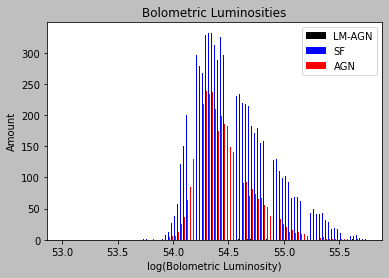

In [25]:
plt.style.use('grayscale')
bins = np.linspace(53, 55.75, 100)
colors = ['k', 'b', 'r']
plt.hist([log_bolometric_lowmetagn, log_bolometric_sf, log_bolometric_agn], bins, label=['LM-AGN', 'SF', 'AGN'], color=colors)

plt.legend(loc='upper right')
plt.title('Bolometric Luminosities')
plt.xlabel('log(Bolometric Luminosity)')
plt.ylabel('Amount')
plt.show()

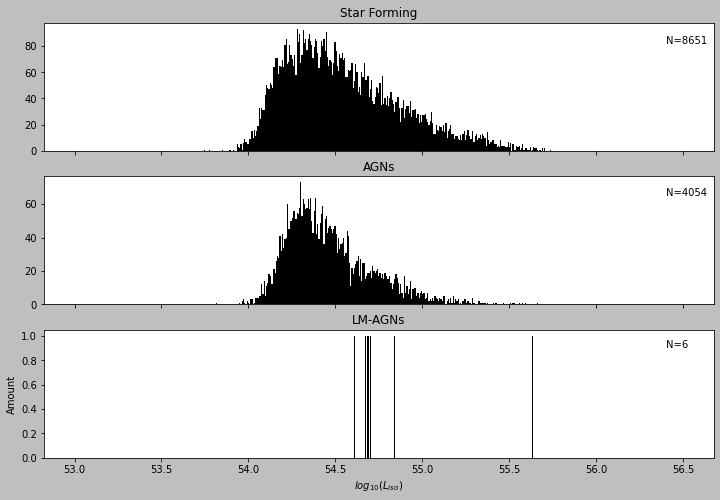

In [31]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(12, 8))
bins = np.linspace(53, 56.5, 500)

sf_hist = axs[0].hist(log_bolometric_sf, bins=bins)
axs[0].set_title('Star Forming')
agn_hist = axs[1].hist(log_bolometric_agn, bins=bins)
axs[1].set_title('AGNs')
lm_agn_hist = axs[2].hist(log_bolometric_lowmetagn, bins=bins)
axs[2].set_title('LM-AGNs')

plt.text(56.4, 3.4, 'N=8651')
plt.text(56.4, 2.15, 'N=4054')
plt.text(56.4, 0.9, 'N=6')

plt.xlabel(r'$log_{10}(L_{iso})$')
plt.ylabel('Amount')
plt.show()

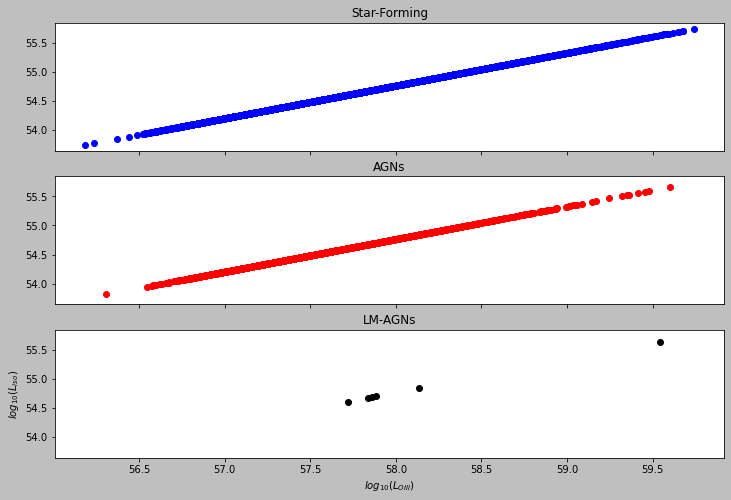

In [27]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(12, 8))

sf_scatter = axs[0].scatter(dfsf['log(o3_lumin)'], dfsf['log(bolo_lumin)'], c='b')
axs[0].set_title('Star-Forming')
agn_scatter = axs[1].scatter(dfagn['log(o3_lumin)'], dfagn['log(bolo_lumin)'], c='r')
axs[1].set_title('AGNs')
lm_agn_scatter = axs[2].scatter(dflowmetagn['log(o3_lumin)'], dflowmetagn['log(bolo_lumin)'], c='k')
axs[2].set_title('LM-AGNs')

plt.ylabel(r'$log_{10}(L_{iso})$')
plt.xlabel(r'$log_{10}(L_{OIII})$')
plt.show()